In [1]:
## circstats
def len2(x):
	if type(x) is not type([]):
		if type(x) is not type(array([])):
			return -1
	return len(x)

def phase2(x):
	if not np.isnan(x):
		return phase(x)
	return nan
    
def circdist(angles1,angles2):
    ''' calculates circular distance of angles [rad]'''
    if len2(angles2) < 0:
        if len2(angles1) > 0:
            angles2 = [angles2]*len(angles1)
        else:
            angles2 = [angles2]
            angles1 = [angles1]
        if len2(angles1) < 0:
            angles1 = [angles1]*len(angles2)
    return array(list(map(lambda a1,a2: phase2(np.exp(1j*a1)/np.exp(1j*a2)), angles1,angles2)))

In [2]:
def read_baseline(filename, mode):
    ''' 
    reads in accuracies/std for 1000x mixed labels per timepoint for r² and MSE evaluation
    INPUT:
        filename:       name of file containing 1000x croxxvalidation on mixed labels
    OUTPUT:
        r2_baseline:    previous accuracy, std and current accuracy, std for the mixed labels R² evaluation
        mse_baseline:   previous accuracy, std and current accuracy, std for the mse evaluation turned into MSE accuracy[%]
    
    '''
    file = io.open(filename, "r")
    contents = file.readlines()

    values = [eval(contents[i]) for i in range(len(contents))]

    if mode == 'r2':
        r2_baseline = {'acc_prev':values[0], 'std_prev':values[1], 'acc_curr':values[2], 'std_curr':values[3]}
        return r2_baseline
        
    elif mode =='MSE':
        #values[4] = 100-np.array(values[4])*100/circdist(0, np.pi)[0]**2#np.pi
        #values[5] = np.array(values[5])*100
        #values[6] = 100-np.array(values[6])*100/circdist(0, np.pi)[0]**2#np.pi
        #values[7] = np.array(values[7])*100
        mse_baseline = {'acc_prev':values[4], 'std_prev':values[5], 'acc_curr':values[6], 'std_curr':values[7]}
        return mse_baseline

    return print('ERROR: mode must either be r2 or MSE.')

## Load data

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from scipy.stats import *
from cmath import phase
from numpy import array
from scipy.sparse import csr_matrix
import urllib
import glob
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score
import statsmodels.formula.api as sf
from sklearn import metrics
from random import randint
import math
import scipy
import io


#!wget https://github.com/MelanieTschiersch/SmithData/blob/main/Sa191226.mat?raw=true # , Pe180728.mat, Wa180222.mat
#!mv Sa191226.mat?raw=true Sa191226.mat #, Pe180728.mat, Sa191226.mat

#!wget https://github.com/comptelab/distributedWM/blob/main/smith/PFC_PFC/Sa191202.mat # , Pe180728.mat, Wa180222.mat
#!mv Sa191226.mat?raw=true Sa191226.mat #, Pe180728.mat, Sa191226.mat
data={'Sa': [], 'Pe':[], 'Wa':[]}
for m in ["Sa", "Pe", "Wa"]:
    files = np.sort(glob.glob('../Data/%s*.mat' %m))
    for f in files:
#data = loadmat('distributedWM/smith/PFC_PFC/Sa191202.mat')#Sa191203
        data[m].append(loadmat(f))
        print(f)
    #files_web = np.sort(glob.glob('%s*.mat' %m))
    #for f in files_web:
    #    data[m].append(loadmat(f))#, Pe180728.mat, Wa180222.mat, Sa191226.mat


../Data/Sa191202.mat
../Data/Sa191203.mat
../Data/Sa191226.mat
../Data/Pe180728.mat
../Data/Wa180222.mat


In [4]:
left_idx = {'Sa': [[] for i in range(len(data['Sa']))], 'Pe':[[] for i in range(len(data['Pe']))], 'Wa':[[] for i in range(len(data['Wa']))]}
right_idx = {'Sa': [[] for i in range(len(data['Sa']))], 'Pe':[[] for i in range(len(data['Pe']))], 'Wa':[[] for i in range(len(data['Wa']))]}
for m in ["Sa", "Pe", "Wa"]:
    for n in range(len(data[m])):
        left_idx[m][n] = data[m][n]['left_idx']
        right_idx[m][n] = data[m][n]['right_idx']


In [5]:
dataset=[]
monkey=[]
session=[]
for m in ['Sa','Pe','Wa']:
    for n in range(len(data[m])):
        for line in data[m][n]['dat'][0]:
            dataset.append([row if not isinstance(row, np.ndarray) else row.flat[0] if len(row[0])==1 else row[0] for row in line])
            monkey.append(m)
            session.append(n)


columns = ['trial_id','sp_train', 'outcome', 'timing', 'targ_xy', 'targ_angle', 'saccade_xy', 'saccade_angle']

df_dat = pd.DataFrame(dataset, columns=columns)
df_dat['monkey'] = monkey
df_dat['session'] = session

In [6]:
taskperiods = ['fix', 'targ_on', 'targ_off', 'go_cue', 'saccade', 'reward']
for i in range(len(taskperiods)):
    df_dat[taskperiods[i]] = [line[i].flat[0] for line in df_dat['timing']]
del df_dat['timing']

In [7]:
df_dat['trial_end'] = [df_dat['sp_train'][n].shape[1] for n in range(len(df_dat['sp_train']))]

### Change WM circle -> 0 on top

In [8]:
help_circle = np.zeros(len(df_dat))
help_circle_sac = np.zeros(len(df_dat))
for idx in range(len(df_dat)):
    if df_dat.targ_angle[idx]<90:
        help_circle[idx] = df_dat.targ_angle[idx]+270
    elif df_dat.targ_angle[idx]==90:
        help_circle[idx] = 0
        help_circle_sac[idx] = 0
    elif df_dat.targ_angle[idx]>90:
        help_circle[idx] = df_dat.targ_angle[idx]-90
    else:
        print('error')
        
    if df_dat.saccade_angle[idx]<90:
        help_circle_sac[idx] = df_dat.saccade_angle[idx]+270
    elif df_dat.saccade_angle[idx]==90:
        help_circle_sac[idx] = 0
    elif df_dat.saccade_angle[idx]>90:
        help_circle_sac[idx] = df_dat.saccade_angle[idx]-90
    else:
        print('error')

df_dat['targ_angle'] = help_circle
df_dat['saccade_angle'] = help_circle_sac
    

In [9]:
x_start=[]
x_label=[]
clockw=[]

for n in range(len(df_dat['targ_on'])):
    x_start.append([])
    x_label.append([])
    x = csr_matrix(df_dat['sp_train'][n])
    x_start[n] = np.sum(x[:,df_dat['targ_on'][n]:df_dat['targ_off'][n]].toarray(), axis=1)
    x_label[n] = df_dat['targ_angle'][n]
    if circdist(df_dat['targ_angle'][n]*np.pi/180, df_dat['saccade_angle'][n]*np.pi/180)<=0:
        clockw.append('CW') 
    else:
        clockw.append('CCW') 

df_dat['n_cue'] = x_start # all neurons during time of cue
df_dat['clockw'] = clockw
df_dat.head()

,trial_id,sp_train,outcome,targ_xy,targ_angle,saccade_xy,saccade_angle,monkey,session,fix,targ_on,targ_off,go_cue,saccade,reward,trial_end,n_cue,clockw
0,1,"(40, 0)\t1.0\n (73, 0)\t1.0\n (51, 1)\t1.0...",CORRECT,"[-81.32022937758153, -196.32440065864844]",157.5,"[-94.13180712732776, -171.71289550644755]",151.268755,Sa,0,1,236,656,3706,3904,4036,4825,"[2.0, 5.0, 37.0, 10.0, 11.0, 5.0, 3.0, 25.0, 1...",CCW
1,2,"(35, 1)\t1.0\n (7, 2)\t1.0\n (12, 2)\t1.0\...",CORRECT,"[196.32440065864844, -81.32022937758153]",247.5,"[181.59180019708026, -74.49810902444511]",247.694090,Sa,0,1,239,659,2189,2391,2519,3288,"[2.0, 12.0, 29.0, 1.0, 8.0, 8.0, 4.0, 26.0, 1....",CW
2,4,"(21, 0)\t1.0\n (68, 0)\t1.0\n (87, 0)\t1.0...",CORRECT,"[-81.32022937758157, 196.32440065864844]",22.5,"[-96.76686414165835, 177.17716528930353]",28.641548,Sa,0,1,239,659,2789,2983,3109,3879,"[1.0, 7.0, 30.0, 2.0, 16.0, 9.0, 9.0, 15.0, 0....",CW
3,5,"(6, 0)\t1.0\n (61, 0)\t1.0\n (71, 0)\t1.0\...",CORRECT,"[-196.32440065864844, 81.3202293775816]",67.5,"[-199.06297645572684, 46.04101453015077]",76.977129,Sa,0,1,239,659,2589,2750,2879,3650,"[2.0, 4.0, 13.0, 6.0, 15.0, 9.0, 2.0, 17.0, 0....",CW
4,6,"(79, 0)\t1.0\n (126, 0)\t1.0\n (1, 2)\t1.0...",CORRECT,"[-196.32440065864844, -81.32022937758155]",112.5,"[-206.4608640384042, -108.05421218627242]",117.625947,Sa,0,1,241,660,3090,3276,3411,4179,"[2.0, 4.0, 15.0, 5.0, 18.0, 17.0, 4.0, 24.0, 0...",CW


# Neural Analysis

### split data into time periods, time bins within each period (delay variances)

In [10]:
#only use Sa, sess0
monkey_chosen = 'Sa'
sess_chosen=2
df_Sa0 = df_dat.loc[(df_dat['monkey']==monkey_chosen) & (df_dat['session']==sess_chosen)]

# make spike trains into csr matrix for each trial
df_Sa0.loc[:,'n_mat'] = [csr_matrix(df_Sa0.loc[n,'sp_train']) for n in df_Sa0['sp_train'].index]


# determine border points between different time periods, until beginning of delay
bins = 200 # TODO! 250ms in Li2021
timings = ['fix','targ_on','targ_off', 'go_cue']#,'saccade', 'reward', 'trial_end']# discrete timings
help = 0
borders=[]
# borders 
for period in range(len(timings)):
    #help += int(min([(df_Sa0.loc[n, timings[period+1]]-df_Sa0.loc[n, timings[period]]) for n in range(len(df_Sa0))])/bins)
    #borders.append(help)
    borders.append(int(min(df_dat[timings[period]]/bins)))
print(borders)

# determine border points INDIVID trials between different time periods, for end of delay
timings2 = ['go_cue','saccade', 'reward', 'trial_end']
t_borders2 = ['delay_start','delay_end','saccade', 'reward', 'trial_end', 'end_start', 'end']#
borders2={'delay_start': [], 'delay_end': [], 'saccade': [], 'reward':[], 'trial_end':[], 'end_start':[], 'end':[]}##np.zeros((len(timings2)+1, len(df_Sa0)))
for i,m in enumerate(borders2.keys()):
    if i==0:
        #create shifted "start" of delay
        borders2[m] = ((df_Sa0['go_cue'].values)/bins - min(((df_Sa0['go_cue'].values-df_Sa0['targ_off'].values)/bins))).astype(int)#
    elif i ==1:
        # delay end
        borders2[m] = ((df_Sa0['go_cue'].values)/bins).astype(int)
        #np.array([int(df_Sa0.loc[n,timings2[0]]/bins)-(borders[-1]) for n in range(len(df_Sa0))])
    elif m =='end_start':
        # shifted "start" of trial end : complete end of trial - minimum(trial_end-reward)
        borders2[m] = [int(df_Sa0.loc[n,'trial_end']/bins)-int(min((df_Sa0.loc[:,'trial_end']-df_Sa0.loc[:,'reward'])/bins)) for n in df_Sa0.index]#
    elif m == 'end':
        borders2[m] = [int(df_Sa0.loc[n,'trial_end']/bins) for n in df_Sa0.index]
    else:
    # create end delay, saccade start, reward start, trial_end through using minimum distance between periods, adding to delay_end, saccade_end,..
        borders2[m] = np.array(borders2[t_borders2[i-1]]) + min([int((df_Sa0.loc[n,timings2[i-1]]-df_Sa0.loc[n,timings2[i-2]])/bins) for n in df_Sa0.index])
    #print(min([int((df_Sa0.loc[n,timings2[period]]- df_Sa0.loc[n,timings2[period-1]])/bins) for n in range(len(df_Sa0))]))
    #np.array(min([int((df_Sa0.loc[n,timings2[period]]- df_Sa0.loc[n,timings2[period-1]]))/bins for n in range(len(df_Sa0))]))

print(borders2)
## add shift between trial short end and trial long start
borders.append(borders[-1]+min(np.array(borders2['trial_end'])- np.array(borders2['delay_start'])))

# add saccade for response period
#borders.append(borders[-1]+min(np.array(borders2['saccade'])- np.array(borders2['delay_end'])))

/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


[0, 1, 3, 10]
{'delay_start': array([4, 5, 5, ..., 5, 3, 3]), 'delay_end': array([11, 12, 12, ..., 12, 11, 11]), 'saccade': array([11, 12, 12, ..., 12, 11, 11]), 'reward': array([11, 12, 12, ..., 12, 11, 11]), 'trial_end': array([14, 15, 15, ..., 15, 14, 14]), 'end_start': [13, 14, 15, 13, 13, 14, 13, 13, 15, 13, 14, 15, 14, 13, 15, 15, 14, 13, 13, 14, 13, 14, 14, 15, 15, 13, 13, 14, 14, 13, 15, 13, 13, 13, 14, 14, 14, 12, 12, 13, 14, 15, 14, 13, 15, 14, 12, 14, 14, 12, 14, 13, 14, 12, 13, 13, 14, 14, 14, 14, 15, 12, 14, 15, 13, 12, 13, 14, 13, 15, 15, 14, 14, 14, 15, 13, 13, 14, 14, 12, 15, 13, 13, 14, 14, 14, 14, 12, 14, 13, 13, 15, 13, 13, 15, 14, 13, 12, 13, 13, 13, 12, 14, 14, 15, 14, 12, 14, 12, 14, 13, 14, 15, 12, 14, 14, 15, 15, 13, 14, 12, 12, 13, 14, 15, 14, 13, 14, 15, 13, 14, 13, 14, 13, 13, 12, 13, 14, 14, 15, 14, 15, 14, 12, 14, 13, 14, 15, 13, 14, 13, 15, 13, 13, 12, 15, 14, 12, 13, 12, 14, 15, 13, 14, 12, 14, 13, 12, 12, 13, 14, 13, 13, 12, 15, 13, 14, 13, 13, 13, 13, 1

In [11]:
bin_sp_trials=[]
period_spikes=[]
for trial in df_Sa0.index:# for all trials
    binned_spikes = []
    for period in range(len(timings[:-1])):# for all discrete timings
        for t in range(borders[period+1]-borders[period]): # for all time bins in discrete timings:           
            # sum the matrix of neurons at timings in bin
            binned_spikes.append(np.sum(df_Sa0.loc[trial, 'n_mat'][:,df_Sa0.loc[trial,timings[period]]+t*bins:df_Sa0.loc[trial,timings[period]]+t*bins+bins].toarray(), axis=1))
        #print(t)
    #print(len(binned_spikes[0]))
    bin_sp_trials.append(binned_spikes)


In [12]:
# for first cut (different delay lengths)
bin_sp_trials_pastdelay=[]
period_spikes=[]
for idx, trial in enumerate(df_Sa0.index):# for all trials
    binned_spikes = []
    number_bins=[]
    for period in range(len(borders2)-1):# for all time periods until trial_end
        if period<4:
            number_bins.append(borders2[t_borders2[period+1]][0]-borders2[t_borders2[period]][0])
            for t in range(borders2[t_borders2[period+1]][0]-borders2[t_borders2[period]][0]): # for number of time bins in discrete timings:           
                # sum the matrix of neurons at timings in bin
                binned_spikes.append(np.sum(df_Sa0.loc[trial, 'n_mat'][:,borders2[t_borders2[period]][idx]*bins+t*bins:borders2[t_borders2[period]][idx]*bins+t*bins+bins].toarray(), axis=1))
        elif period>4:
            number_bins.append(borders2[t_borders2[period+1]][0]-borders2[t_borders2[period]][0])
            for t in range(borders2[t_borders2[period+1]][0]-borders2[t_borders2[period]][0]): # for number of time bins in discrete timings:           
                # sum the matrix of neurons at timings in bin
                binned_spikes.append(np.sum(df_Sa0.loc[trial, 'n_mat'][:,borders2[t_borders2[period]][idx]*bins+t*bins:borders2[t_borders2[period]][idx]*bins+t*bins+bins].toarray(), axis=1))

    #print(len(binned_spikes[0]))
    bin_sp_trials_pastdelay.append(binned_spikes)

bin_sp_complete = np.append(bin_sp_trials,bin_sp_trials_pastdelay, axis=1)

# add to dataframe
bin_s=[]
for trial,idx in enumerate(df_Sa0.index):
    bin_s.append(bin_sp_complete[trial])
df_Sa0['bin_sp']=bin_s

/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [13]:
borders_full=[]
borders_full = np.append(borders[:-1],borders[-2]+number_bins[0])
for i in range(1,len(number_bins)):
    borders_full = np.append(borders_full,borders_full[-1]+number_bins[i])
#borders_full = np.append(borders_full,borders_full[-1]+borders2['reward'][0]-borders2['saccade'][0])
#borders_full = np.append(borders_full,borders_full[-1]+borders2['trial_end'][0]-borders2['reward'][0])
#borders_full = np.append(borders_full,borders_full[-1]+borders2['end'][0]-borders2['trial_end'][0])

borders_pastdelay = borders_full[len(borders):]

hemispheres

In [14]:
# idx neurons each hemispheres
left = np.where(left_idx[monkey_chosen][sess_chosen]==1)[1]#
right = np.where(right_idx[monkey_chosen][sess_chosen]==1)[1]

# target position left/right
targ_left = np.where((df_Sa0['targ_angle']>0) & (df_Sa0['targ_angle']<np.pi))[0]
targ_right = np.where((df_Sa0['targ_angle']>np.pi) & (df_Sa0['targ_angle']<2*np.pi))[0]

# CW, CCW analysis

## CW vs CCW decoding  during mean of end-aligned delay

In [15]:
def decode_response_leave1out(dataframe,y):
    """Leave-1-out crossvalidation on neural data. Response decoding during end of delay period
    
    INPUT:      dataframe = pd Dataframe of a single session, all trials
                y         = targets for each trial
                
    OUTPUT:     pred_error = circular distance of predicted response with response for each trial
                pred_sign  = sign of prediction error
    
    """
    pred_error=[]
    pred_clockw=[]
    
    # Leave one out crossvalidation
    loo = LeaveOneOut()
    for train_idx, test_idx in loo.split(dataframe):
        # only train on the time of the end of the delay (backwards aligned delay 2nd half of delay)
        #delta_t_train = borders_full[3:5]# 
        # create training dataset: columns=neurons, rows=trials for previous/current trials
        X = pd.DataFrame([np.mean(dataframe['bin_sp'][n][borders_full[3]:borders_full[4]], axis=0) for n in dataframe.index])

        #X = pd.DataFrame([dataframe['bin_sp'][n][delta_t_train[n-min(dataframe.index)]] for n in dataframe.index])
      
        X_train, X_test = X.loc[train_idx], X.loc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # determine labels (sine, cosine)
        y_train_cos = np.cos(y_train)
        y_train_sin = np.sin(y_train)

        # make linear regression fit for sin/cosine for prev/current trial
        model_cos = LinearRegression().fit(X_train, y_train_cos)
        model_sin = LinearRegression().fit(X_train, y_train_sin)

        # make predictions of models
        preds_cos = model_cos.predict(X_test)
        preds_sin = model_sin.predict(X_test)

        preds = [math.atan2(preds_sin[n],preds_cos[n]) for n in range(len(preds_sin))]

        # distance between prediction, result
        pred_error.append(circdist(preds, y_test))
        pred_clockw.append(['CW' if np.sign(circdist(preds, y_test))[n]>0 else 'CCW' for n in range(len(np.sign(circdist(preds, y_test))))])

    return pred_error, pred_clockw


In [16]:
y = df_Sa0['targ_angle'].values*np.pi/180-np.pi # convert to radians in [-np.pi, np.pi]
df_onetrial = df_Sa0.reset_index()
pred_error, pred_clockw = decode_response_leave1out(df_onetrial,y)

In [60]:
acc_large=[]
acc_cont=[]
for cut in range(50):# for each degree until maximum degree
    acc_large.append(accuracy_score(df_Sa0.loc[abs(np.array(pred_error)*180/np.pi)>cut,'clockw'].values=='CW',\
                                    np.array(pred_error)[abs(np.array(pred_error)*180/np.pi)>cut]>0))
    acc_cont.append(np.mean(circdist(circdist(df_Sa0['saccade_angle'].values*np.pi/180,df_Sa0['targ_angle'].values*np.pi/180)[np.concatenate(abs(np.array(pred_error)*180/np.pi)>cut)], np.concatenate(pred_error)[np.concatenate(abs(np.array(pred_error)*180/np.pi)>cut)])**2)*(-1))
    

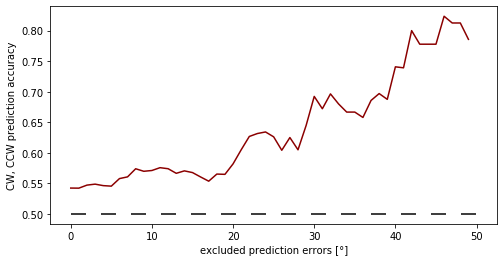

In [180]:
plt.figure(figsize=(8,4))
plt.plot(acc_large, color='darkred')
plt.plot([0,50],[0.5,0.5], dashes=[10,10], color='k')
plt.xlabel('excluded prediction errors [°]')
plt.ylabel('CW, CCW prediction accuracy')
#plt.savefig('../Figures/Neural/CWvsCCW/CWvsCCWpredictionAcc.png', dpi=100)
plt.show()

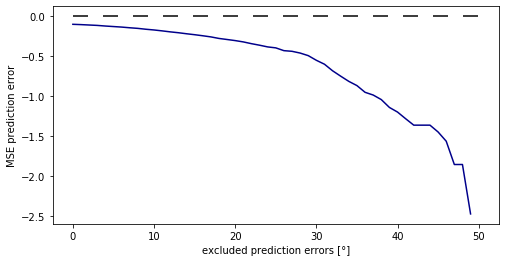

In [62]:
plt.figure(figsize=(8,4))
plt.plot(acc_cont, color='darkblue')
plt.plot([0,50],[0,0], dashes=[10,10], color='k')
plt.xlabel('excluded prediction errors [°]')
plt.ylabel('inverted MSE prediction error')
#plt.savefig('../Figures/Neural/CWvsCCW/CWvsCCWpredictionAcc.png', dpi=100)
plt.show()


## CW/CCW over time steps in delay, DELAY DECODER

In [65]:
def decode_response_leave1out_timeTrain(dataframe,y):
    """Leave-1-out crossvalidation on neural data. Response decoding during end of delay period
    
    INPUT:      dataframe = pd Dataframe of a single session, all trials
                y         = targets for each trial
                
    OUTPUT:     pred_error = circular distance of predicted response with response for each trial
                pred_sign  = sign of prediction error
    
    """
    pred_error=[]
    pred_clockw=[]
    pred_angle=[]
    
    # Leave one out crossvalidation
    loo = LeaveOneOut()
    for train_idx, test_idx in loo.split(dataframe): 
        # create training dataset: columns=neurons, rows=trials for previous/current trials, train during end of delay
        X = pd.DataFrame([np.mean(dataframe['bin_sp'][n][borders_full[3]:borders_full[4]], axis=0) for n in dataframe.index])
        
        X_train = X.loc[train_idx] # training stays constant 
        y_train, y_test = y[train_idx], y[test_idx]
        
        # determine labels (sine, cosine)
        y_train_cos = np.cos(y_train)
        y_train_sin = np.sin(y_train)
        
        # make linear regression fit for sin/cosine for prev/current trial
        model_cos = LinearRegression().fit(X_train, y_train_cos)
        model_sin = LinearRegression().fit(X_train, y_train_sin)
        
        pred_error_bin=[]
        pred_clockw_bin=[]
        pred_angle_bin=[]
        # predict during entire delay, varying bins
        for delta_t_train in range(borders_full[3], borders_full[4]):# test during entire delay 
            X_test = pd.DataFrame(dataframe['bin_sp'][test_idx[0]][delta_t_train])  # only change testing data in time  
            X_test = X_test.transpose()

            # make predictions of models
            preds_cos = model_cos.predict(X_test)
            preds_sin = model_sin.predict(X_test)

            preds = [math.atan2(preds_sin[n],preds_cos[n]) for n in range(len(preds_sin))]

            # distance between prediction, result
            pred_error_bin.append(circdist(preds, y_test))
            pred_clockw_bin.append(['CW' if np.sign(circdist(preds, y_test))[n]>0 else 'CCW' for n in range(len(np.sign(circdist(preds, y_test))))])
            pred_angle_bin.append(preds)
        pred_error.append(pred_error_bin)
        pred_clockw.append(pred_clockw_bin)
        pred_angle.append(pred_angle_bin)
    return pred_error, pred_clockw, pred_angle


In [342]:
y = df_Sa0['targ_angle'].values*np.pi/180-np.pi # convert to radians in [-np.pi, np.pi]
df_onetrial = df_Sa0.reset_index()
pred_error, pred_clockw, pred_angle = decode_response_leave1out_timeTrain(df_onetrial,y)


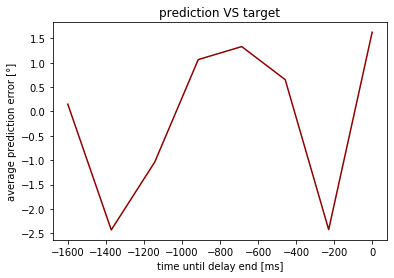

In [343]:
x_acc = np.linspace((borders_full[3]-borders_full[4])*bins,0,borders_full[4]-borders_full[3])
plt.figure()
plt.plot(x_acc,np.mean(np.array(pred_error)*180/np.pi,axis=0), color='darkred')
plt.xlabel('time until delay end [ms]')
plt.ylabel('average prediction error [°]')
plt.title('prediction VS target')
plt.show()

-> this increases because over longer delays, response acc decreases

In [344]:
cut_off = 5 # trials with error<cut_off are excluded from analysis

binaryAcc_time=[]
contAcc_time=[]
contAcc_time_p=[]
contAcc_pearson=[]
for t in range(len(pred_clockw[0])):
    pred_cw = np.concatenate([pred_clockw[n][t] for n in range(len(pred_clockw))]) # for one time point, each trial determine predictions
    pred_cont = np.concatenate([pred_angle[n][t] for n in range(len(pred_angle))]) # for one time point, each trial determine predictions

    # only evaluate where prediction error is larger cut_off value (safer predictions)
    err_idx = np.where(np.array(np.concatenate([pred_error[n][t] for n in df_onetrial.index]))*180/np.pi>cut_off)[0]
    binaryAcc_time.append(accuracy_score(df_onetrial['clockw'].values[err_idx], pred_cw[err_idx]))
    contAcc_time.append(np.mean((circdist(df_onetrial['saccade_angle'].values[err_idx]*np.pi/180-np.pi, (pred_cont[err_idx]))**2)))
    contAcc_pearson.append(pearsonr(df_onetrial['saccade_angle'].values[err_idx]*np.pi/180-np.pi, pred_cont[err_idx])[0])
    #df_Sa0['saccade_angle'].values
    

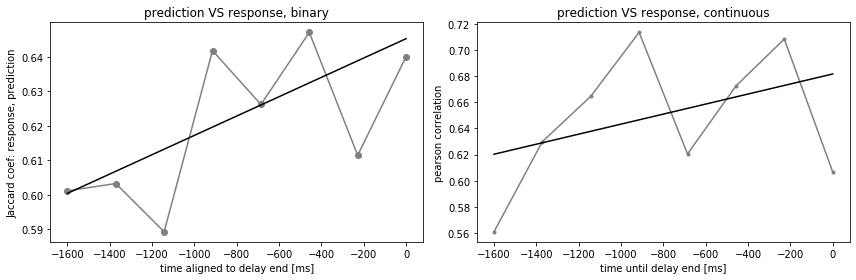

In [345]:
# make linear fit
X = (np.arange(-len(binaryAcc_time),0)*bins)
params1 = LinearRegression().fit(X.reshape(-1,1), np.array(binaryAcc_time).reshape(-1,1))
params2 = LinearRegression().fit(X.reshape(-1,1), np.array(contAcc_pearson).reshape(-1,1))

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(x_acc,binaryAcc_time, color='grey', marker='o')
plt.plot(x_acc, params1.coef_[0]*x_acc+params1.intercept_[0], color='k')
plt.xlabel('time aligned to delay end [ms]')
plt.ylabel('Jaccard coef: response, prediction')
plt.title('prediction VS response, binary')

plt.subplot(122)
plt.plot(x_acc,contAcc_pearson, color='grey', marker='.')
plt.plot(x_acc, params2.coef_[0]*x_acc+params2.intercept_[0], color='k')
plt.xlabel('time until delay end [ms]')
plt.ylabel('pearson correlation')
plt.title('prediction VS response, continuous')
plt.tight_layout()
#plt.savefig('../Figures/Neural/CWvsCCW/CWvsCCWdecoding_DelayDecoder_5cutoff_Wa0.png', dpi=200)
plt.show()

# CW/CCW over time, separate hemispheres, DELAY DECODER

In [18]:
x_acc = np.linspace((borders_full[3]-borders_full[4])*bins,0,borders_full[4]-borders_full[3])

y_singleTrial = df_Sa0['targ_angle'].values*np.pi/180 # convert to radians in [-np.pi, np.pi]
targ_left_singleTrial = np.where((y_singleTrial>0) & (y_singleTrial<np.pi))[0]
targ_right_singleTrial = np.where((y_singleTrial>np.pi) & (y_singleTrial<2*np.pi))[0]
y_singleTrial=y_singleTrial-np.pi

In [19]:
# create dataframe with only left neurons (SINGLE trials)
df_Sa0 = df_Sa0.reset_index()
df_Sa0_left = df_Sa0.copy()# ['bin_sp_prev'][0][0][left]
df_Sa0_left.drop(['bin_sp'], axis=1)
df_Sa0_left['bin_sp'] = [[df_Sa0['bin_sp'][n][t][left] for t in range(len(df_Sa0['bin_sp'][n]))] for n in range(len(df_Sa0['bin_sp']))]

# only right neurons (SINGLE trials)
df_Sa0_right = df_Sa0.copy()# ['bin_sp_prev'][0][0][left]
df_Sa0_right.drop(['bin_sp'], axis=1)
df_Sa0_right['bin_sp'] = [[df_Sa0['bin_sp'][n][t][right] for t in range(len(df_Sa0['bin_sp'][n]))] for n in range(len(df_Sa0['bin_sp']))]


decode CW/CCW through left, right hemisphere decoder

In [348]:
y_singleTrial = df_Sa0['targ_angle'].values*np.pi/180-np.pi # convert to radians in [-np.pi, np.pi]
# left hemisphere
pred_error_left, pred_clockw_left, pred_angle_left = decode_response_leave1out_timeTrain(df_Sa0_left,y_singleTrial)


In [349]:
# right hemisphere
pred_error_right, pred_clockw_right, pred_angle_right = decode_response_leave1out_timeTrain(df_Sa0_right,y_singleTrial)


Determine accuracies within, between hemispheres

In [350]:
# decode CW/CCW accuracy for left, right hemisphere
error_singletrial = circdist(df_Sa0['saccade_angle'].values*np.pi/180,df_Sa0['targ_angle'].values*np.pi/180)
cut_off = 5 # trials with error<cut_off are excluded from analysis

binaryAcc_left=[]
contAcc_left=[]
binaryAcc_right=[]
contAcc_right=[]
pearsAcc_left=[]
pearsAcc_right=[]
binaryAcc_both=[]
pearsonAcc_both=[]
#contAcc_left_p=[]
for t in range(len(pred_clockw_left[0])):
    pred_cw_left = np.concatenate([pred_clockw_left[n][t] for n in range(len(pred_clockw_left))]) # for one time point, each trial determine predictions
    pred_cw_right = np.concatenate([pred_clockw_right[n][t] for n in range(len(pred_clockw_right))]) # for one time point, each trial determine predictions
    pred_cont_left = np.concatenate([pred_error_left[n][t] for n in range(len(pred_error_left))]) # for one time point, each trial determine predictions
    pred_cont_right = np.concatenate([pred_error_right[n][t] for n in range(len(pred_error_right))]) # for one time point, each trial determine predictions

    # LEFT: only evaluate where prediction error is larger cut_off value (safer predictions)
    # only use trials where prediction error is larger than cut-off
    err_idx_left = np.where(np.array(np.concatenate([pred_error_left[n][t] for n in df_Sa0_left.index]))*180/np.pi>cut_off)[0]
    # calculate binary accuracy of CW/CCW trials
    binaryAcc_left.append(accuracy_score(df_Sa0_left['clockw'].values[err_idx_left], pred_cw_left[err_idx_left]))
    # calculate continuous accuracy of CW/CCW trials
    contAcc_left.append(np.mean((circdist(error_singletrial[err_idx_left], pred_cont_left[err_idx_left])**2)))
    pearsAcc_left.append(pearsonr(error_singletrial[err_idx_left], pred_cont_left[err_idx_left]))
    
    # Right: only evaluate where prediction error is larger cut_off value (safer predictions)
    err_idx_right = np.where(np.array(np.concatenate([pred_error_right[n][t] for n in df_Sa0_right.index]))*180/np.pi>cut_off)[0]
    binaryAcc_right.append(accuracy_score(df_Sa0_right['clockw'].values[err_idx_right], pred_cw_right[err_idx_right]))
    contAcc_right.append(np.mean((circdist(error_singletrial[err_idx_right], pred_cont_right[err_idx_right])**2)))
    pearsAcc_right.append(pearsonr(error_singletrial[err_idx_right], pred_cont_right[err_idx_right]))

    # correlation between both hemispere predictions
    binaryAcc_both.append(accuracy_score(pred_cw_left, pred_cw_right))
    pearsonAcc_both.append(pearsonr(pred_cont_left, pred_cont_right))
pearsonAcc_both=np.array(pearsonAcc_both)
pearsAcc_right=np.array(pearsAcc_right)
pearsAcc_left=np.array(pearsAcc_left)

plot similarity accuracy over time

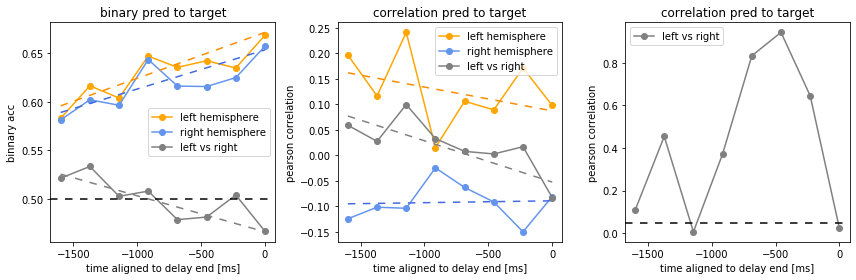

In [351]:
# make linear fit
X = (np.arange(-len(binaryAcc_left),0)*bins)
params_left = LinearRegression().fit(X.reshape(-1,1), np.array(binaryAcc_left).reshape(-1,1))
params_right = LinearRegression().fit(X.reshape(-1,1), np.array(binaryAcc_right).reshape(-1,1))
params_lr = LinearRegression().fit(X.reshape(-1,1), np.array(binaryAcc_both).reshape(-1,1))
params_pears_left = LinearRegression().fit(X.reshape(-1,1), np.array(pearsAcc_left[:,0]).reshape(-1,1))
params_pears_right = LinearRegression().fit(X.reshape(-1,1), np.array(pearsAcc_right[:,0]).reshape(-1,1))
params_pears_lr = LinearRegression().fit(X.reshape(-1,1), np.array(pearsonAcc_both[:,0]).reshape(-1,1))

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(x_acc,binaryAcc_left, color='orange', marker='o', label='left hemisphere')
plt.plot(x_acc,binaryAcc_right, color='cornflowerblue', marker='o', label='right hemisphere')
plt.plot(x_acc, binaryAcc_both, color='grey', marker='o', label='left vs right')
plt.plot(x_acc, params_left.coef_[0]*x_acc+params_left.intercept_[0], dashes=[5,5], color='darkorange')
plt.plot(x_acc, params_right.coef_[0]*x_acc+params_right.intercept_[0], dashes=[5,5], color='royalblue')
plt.plot(x_acc, params_lr.coef_[0]*x_acc+params_lr.intercept_[0], dashes=[5,5], color='grey')
plt.axhline(0.5, color='k', dashes=[5,5])
plt.xlabel('time aligned to delay end [ms]')
plt.ylabel('binnary acc')
plt.title('binary pred to target')
plt.legend()

plt.subplot(132)
plt.plot(x_acc,pearsAcc_left[:,0], color='orange', marker='o', label='left hemisphere')
plt.plot(x_acc,pearsAcc_right[:,0], color='cornflowerblue', marker='o', label='right hemisphere')
plt.plot(x_acc, pearsonAcc_both[:,0], color='grey', marker='o', label='left vs right')
plt.plot(x_acc, params_pears_left.coef_[0]*x_acc+params_pears_left.intercept_[0], dashes=[5,5], color='darkorange')
plt.plot(x_acc, params_pears_right.coef_[0]*x_acc+params_pears_right.intercept_[0], dashes=[5,5], color='royalblue')
plt.plot(x_acc, params_pears_lr.coef_[0]*x_acc+params_pears_lr.intercept_[0], dashes=[5,5], color='grey')
plt.xlabel('time aligned to delay end [ms]')
plt.ylabel('pearson correlation')
plt.title('correlation pred to target')
plt.legend()
plt.tight_layout()
#plt.savefig('../Figures/Neural/CWvsCCW/hemispheres/CWvsCCWdecoding_DelayDecoder_DecodingLeftRightBoth_Sa0.png', dpi=200)

plt.subplot(133)
#plt.plot(x_acc,pearsAcc_left[:,1], color='orange', marker='o', label='left hemisphere')
#plt.plot(x_acc,pearsAcc_right[:,1], color='cornflowerblue', marker='o', label='right hemisphere')
plt.plot(x_acc, pearsonAcc_both[:,1], color='grey', marker='o', label='left vs right')
plt.axhline(0.05, color='k', dashes=[5,5])
plt.xlabel('time aligned to delay end [ms]')
plt.ylabel('pearson correlation')
plt.title('correlation pred to target')
plt.legend()
plt.tight_layout()
#plt.savefig('../Figures/Neural/CWvsCCW/hemispheres/CWvsCCWdecoding_DelayDecoder_DecodingLeftRightBoth_Sa0.png', dpi=200)
plt.show()

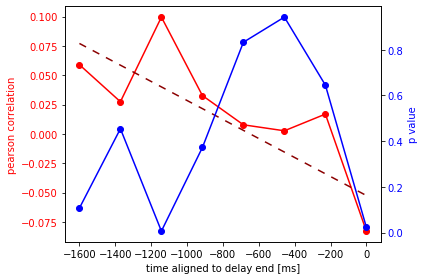

In [352]:
fig, ax1 = plt.subplots()
ax1.plot(x_acc, pearsonAcc_both[:,0], color='red', marker='o', label='left vs right')
ax1.plot(x_acc, params_pears_lr.coef_[0]*x_acc+params_pears_lr.intercept_[0], dashes=[5,5], color='darkred')
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_xlabel('time aligned to delay end [ms]')
ax1.set_ylabel('pearson correlation',color='red')

ax2 = ax1.twinx()
ax2.set_ylabel('p value', color='blue')
ax2.plot(x_acc, pearsonAcc_both[:,1], color='blue', marker='o', label='left vs right')
ax2.tick_params(axis='y', labelcolor='blue')
plt.tight_layout()
#plt.savefig('../Figures/Neural/CWvsCCW/hemispheres/PearsonCorrelationHemispheresLeftRight_DelayDecoder_Wa0.png', dpi=200)
plt.show()

ipsi vs contra

In [193]:
# decode CW/CCW accuracy for left, right hemisphere


binaryAcc_left_ipsi=[]
binaryAcc_left_contra=[]
binaryAcc_right_ipsi=[]
binaryAcc_right_contra=[]
acc_acrossHemi_left=[]
acc_acrossHemi_right=[]
#contAcc_left_p=[]
for t in range(len(pred_clockw_left[0])):
    pred_cw_left = np.concatenate([pred_clockw_left[n][t] for n in range(len(pred_clockw_left))]) # for one time point, each trial determine predictions
    pred_cw_right = np.concatenate([pred_clockw_right[n][t] for n in range(len(pred_clockw_right))]) # for one time point, each trial determine predictions
    pred_cont_left = np.concatenate([pred_angle_left[n][t] for n in range(len(pred_angle_left))]) # for one time point, each trial determine predictions
    pred_cont_right = np.concatenate([pred_angle_right[n][t] for n in range(len(pred_angle_right))]) # for one time point, each trial determine predictions

    # LEFT: only evaluate where prediction error is larger cut_off value (safer predictions)
    # only use trials where prediction error is larger than cut-off
    # calculate binary accuracy of CW/CCW trials
    binaryAcc_left_ipsi.append(accuracy_score(df_Sa0_left.loc[targ_left_singleTrial]['clockw'].values, pred_cw_left[targ_left_singleTrial]))
    binaryAcc_left_contra.append(accuracy_score(df_Sa0_left.loc[targ_right_singleTrial]['clockw'].values, pred_cw_left[targ_right_singleTrial]))

    # Right: only evaluate where prediction error is larger cut_off value (safer predictions)
    binaryAcc_right_ipsi.append(accuracy_score(df_Sa0_right.loc[targ_right_singleTrial]['clockw'].values, pred_cw_right[targ_right_singleTrial]))
    binaryAcc_right_contra.append(accuracy_score(df_Sa0_right.loc[targ_left_singleTrial]['clockw'].values, pred_cw_right[targ_left_singleTrial]))
    
    acc_acrossHemi_left.append(accuracy_score(pred_cw_left[targ_left_singleTrial], pred_cw_right[targ_left_singleTrial]))
    acc_acrossHemi_right.append(accuracy_score(pred_cw_left[targ_right_singleTrial], pred_cw_right[targ_right_singleTrial]))

BINARY

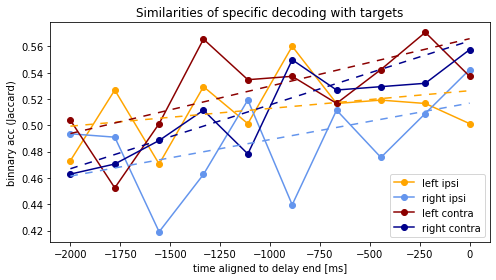

In [194]:
# make linear fit
X = (np.arange(-len(binaryAcc_left_ipsi),0)*bins)
params_left_ipsi = LinearRegression().fit(X.reshape(-1,1), np.array(binaryAcc_left_ipsi).reshape(-1,1))
params_right_ipsi = LinearRegression().fit(X.reshape(-1,1), np.array(binaryAcc_right_ipsi).reshape(-1,1))
params_left_contra = LinearRegression().fit(X.reshape(-1,1), np.array(binaryAcc_left_contra).reshape(-1,1))
params_right_contra = LinearRegression().fit(X.reshape(-1,1), np.array(binaryAcc_right_contra).reshape(-1,1))

plt.figure(figsize=(7,4))
plt.plot(x_acc,binaryAcc_left_ipsi, color='orange', marker='o', label='left ipsi')
plt.plot(x_acc,binaryAcc_right_ipsi, color='cornflowerblue', marker='o', label='right ipsi')
plt.plot(x_acc,binaryAcc_left_contra, color='darkred', marker='o', label='left contra')
plt.plot(x_acc,binaryAcc_right_contra, color='darkblue', marker='o', label='right contra')
plt.plot(x_acc, params_left_ipsi.coef_[0]*x_acc+params_left_ipsi.intercept_[0], dashes=[5,5], color='orange')
plt.plot(x_acc, params_right_ipsi.coef_[0]*x_acc+params_right_ipsi.intercept_[0], dashes=[5,5], color='cornflowerblue')
plt.plot(x_acc, params_left_contra.coef_[0]*x_acc+params_left_contra.intercept_[0], dashes=[5,5], color='darkred')
plt.plot(x_acc, params_right_contra.coef_[0]*x_acc+params_right_contra.intercept_[0], dashes=[5,5], color='darkblue')
plt.xlabel('time aligned to delay end [ms]')
plt.ylabel('binnary acc (Jaccard)')
plt.title('Similarities of specific decoding with targets')
plt.legend()
plt.tight_layout()
#plt.savefig('../Figures/Neural/CWvsCCW/hemispheres/CWvsCCWdecoding_HemiTargets.png', dpi=200)
plt.show()

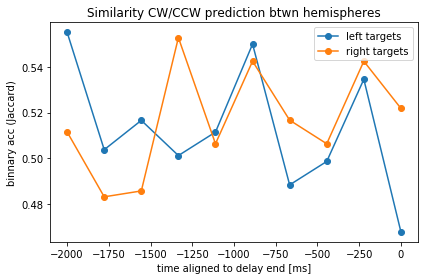

In [195]:
plt.figure()
plt.plot(x_acc,acc_acrossHemi_left, 'o-', label='left targets')
plt.plot(x_acc,acc_acrossHemi_right, 'o-',label='right targets')
plt.xlabel('time aligned to delay end [ms]')
plt.ylabel('binnary acc (Jaccard)')
plt.title('Similarity CW/CCW prediction btwn hemispheres')
plt.legend()
plt.tight_layout()
#plt.savefig('../Figures/Neural/CWvsCCW/hemispheres/CWvsCCWdecoding_Targets_JaccardBTWNHemis.png', dpi=200)
plt.show()

## Correlation between CW/CCW decoding across hemispheres, DELAY DECODER

scatterplot and linear regression fit of left vs right hemisphere predictions (mean across delay end)

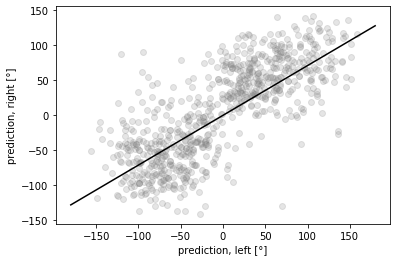

In [160]:
x_ang = np.linspace(-180,180,500)
params = LinearRegression().fit(np.mean(pred_angle_left, axis=1).reshape(-1,1), np.mean(pred_angle_right, axis=1).reshape(-1,1))

plt.figure()
plt.scatter(np.mean(pred_angle_left, axis=1)*180/np.pi, np.mean(pred_angle_right, axis=1)*180/np.pi, color='grey', alpha=0.2)
plt.plot(x_ang, params.coef_[0]*x_ang+params.intercept_[0], color='k')
plt.xlabel('prediction, left [°]')
plt.ylabel('prediction, right [°]')
#plt.savefig('../Figures/Neural/CWvsCCW/hemispheres/CWvsCCWCorrelation_LeftRight.png', dpi=200)
plt.show()

### Constant decoder (delay-decoder)

R² score across time during the delay between hemispheres (how aligned are hemisphere predictions during the delay)

IndexError: index 30 is out of bounds for axis 1 with size 10

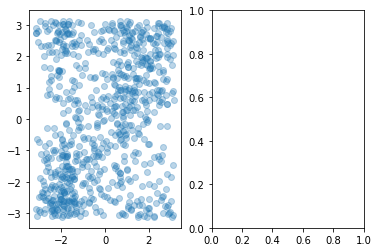

In [196]:
pred_angle_left = np.array(pred_angle_left)
pred_angle_right = np.array(pred_angle_right)

plt.figure()
plt.subplot(121)
plt.scatter(pred_angle_left[:,0], pred_angle_right[:,0], alpha=0.3)
plt.subplot(122)
plt.scatter(pred_angle_left[:,30], pred_angle_right[:,30], alpha=0.3)
plt.show()

In [ ]:
y_singleTrial = df_Sa0['targ_angle'].values*np.pi/180 # convert to radians in [-np.pi, np.pi]
targ_left_singleTrial = np.where((y_singleTrial>0) & (y_singleTrial<np.pi))[0]
targ_right_singleTrial = np.where((y_singleTrial>np.pi) & (y_singleTrial<2*np.pi))[0]
response_singleTrial = df_Sa0['saccade_angle'].values*np.pi/180-np.pi
y_singleTrial = y_singleTrial-np.pi

In [ ]:
r2_lr=[]# hemisphere correlation
r2_li=[]# correlation left ipsi with target
r2_lc=[]# correlation left contra with target
r2_ri=[]# correlation right ipsi with target
r2_rc=[]# correlation right contra with target
pears_lr=[]
pears_li=[]
pears_lc=[]
pears_ri=[]
pears_rc=[]
pears_lirc=[]
pears_lcri=[]
for i in range(len(pred_angle_left[0])): # for each time step
    # between hemispheres
    dat ={'x': np.concatenate(pred_angle_left, axis=1)[i,:], 'y':np.concatenate(pred_angle_right, axis=1)[i,:]}
    mod=sf.ols('y~x',data=dat)
    res=mod.fit()
    r2_lr.append(res.rsquared)
    pears_lr.append(pearsonr(np.concatenate(pred_angle_left, axis=1)[i,:], np.concatenate(pred_angle_right, axis=1)[i,:])[0])
    
    # Compare to target position
    # left, ipsilateral
    dat ={'x': np.concatenate(pred_angle_left, axis=1)[i,targ_left_singleTrial], 'y':response_singleTrial[targ_left_singleTrial]}
    mod=sf.ols('y~x',data=dat)
    res=mod.fit()
    r2_li.append(res.rsquared)
    pears_li.append(pearsonr(np.concatenate(pred_angle_left, axis=1)[i,targ_left_singleTrial], response_singleTrial[targ_left_singleTrial])[0])
    # left, contralateral
    dat ={'x': np.concatenate(pred_angle_left, axis=1)[i,targ_right_singleTrial], 'y':response_singleTrial[targ_right_singleTrial]}
    mod=sf.ols('y~x',data=dat)
    res=mod.fit()
    r2_lc.append(res.rsquared)
    pears_lc.append(pearsonr(np.concatenate(pred_angle_left, axis=1)[i,targ_right_singleTrial], response_singleTrial[targ_right_singleTrial])[0])
    # right, ipsilateral
    dat ={'x': np.concatenate(pred_angle_right, axis=1)[i,targ_right_singleTrial], 'y':response_singleTrial[targ_right_singleTrial]}
    mod=sf.ols('y~x',data=dat)
    res=mod.fit()
    r2_ri.append(res.rsquared)
    pears_ri.append(pearsonr(np.concatenate(pred_angle_right, axis=1)[i,targ_right_singleTrial], response_singleTrial[targ_right_singleTrial])[0])
    # right, contralateral
    dat ={'x': np.concatenate(pred_angle_right, axis=1)[i,targ_left_singleTrial], 'y':response_singleTrial[targ_left_singleTrial]}
    mod=sf.ols('y~x',data=dat)
    res=mod.fit()
    r2_rc.append(res.rsquared)
    pears_rc.append(pearsonr(np.concatenate(pred_angle_right, axis=1)[i,targ_left_singleTrial], response_singleTrial[targ_left_singleTrial])[0])
    
    # across hemispheres
    pears_lirc.append(pearsonr(np.concatenate(pred_angle_left, axis=1)[i,targ_left_singleTrial], np.concatenate(pred_angle_right, axis=1)[i,targ_left_singleTrial])[0])
    pears_lcri.append(pearsonr(np.concatenate(pred_angle_left, axis=1)[i,targ_right_singleTrial], np.concatenate(pred_angle_right, axis=1)[i,targ_right_singleTrial])[0])


In [ ]:
plt.figure(figsize=(6,4))
#plt.subplot(121)
#plt.plot(x_acc,r2_lr, color='darkred', label='r²')
#plt.axhline(0, dashes=[5,5], color='grey')
#plt.xlabel('time aligned to delay end [ms]')
#plt.ylabel('R² score between hemispheres')

plt.plot(x_acc,pears_lr, color='darkblue', label='pearson')
plt.xlabel('time aligned to delay end [ms]')
plt.ylabel('pearson correlation between hemispheres')
#plt.legend()
plt.tight_layout()
#plt.savefig('../Figures/Neural/CWvsCCW/hemispheres/Hemispheres_predictionCorrelation_DelayDecoder.png', dpi=200)
plt.show()

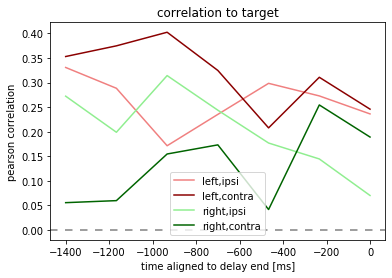

In [110]:
plt.figure(figsize=(6,4))
plt.plot(x_acc,pears_li, color='lightcoral', label='left,ipsi')
plt.plot(x_acc,pears_lc, color='darkred', label='left,contra')
plt.plot(x_acc,pears_ri, color='lightgreen', label='right,ipsi')
plt.plot(x_acc,pears_rc, color='darkgreen', label='right,contra')
plt.axhline(0, dashes=[5,5], color='grey')
plt.xlabel('time aligned to delay end [ms]')
plt.ylabel('pearson correlation')
plt.title('correlation to target')
plt.legend()

#plt.savefig('../Figures/Neural/CWvsCCW/hemispheres/Hemispheres_predictionCorrelation_DelayDecoder.png', dpi=200)
plt.show()

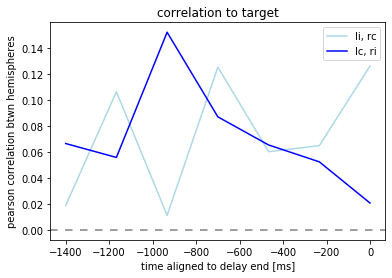

In [111]:
plt.figure(figsize=(6,4))
plt.plot(x_acc,pears_lirc, color='lightblue', label='li, rc')
plt.plot(x_acc,pears_lcri, color='blue', label='lc, ri')
plt.axhline(0, dashes=[5,5], color='grey')
plt.xlabel('time aligned to delay end [ms]')
plt.ylabel('pearson correlation btwn hemispheres')
plt.title('correlation to target')
plt.legend()

#plt.savefig('../Figures/Neural/CWvsCCW/hemispheres/Hemispheres_predictionCorrelation_DelayDecoder.png', dpi=200)
plt.show()

# CW/CCW decoding across hemispheres, CONTINUOUS DECODER

In [16]:
def decode_response_leave1out_timeTrainTest(dataframe,y):
    """Leave-1-out crossvalidation on neural data. Response decoding continuous during delay end (train, test vary)
    
    INPUT:      dataframe = pd Dataframe of a single session, all trials
                y         = targets for each trial
                
    OUTPUT:     pred_error = circular distance of predicted response with response for each trial
                pred_sign  = sign of prediction error
    
    """
    pred_error=[]
    pred_clockw=[]
    pred_angle=[]
    
    # Leave one out crossvalidation
    loo = LeaveOneOut()
    for train_idx, test_idx in loo.split(dataframe): 
        # predict during entire delay, varying bins
        pred_error_bin=[]
        pred_clockw_bin=[]
        pred_angle_bin=[]
        for delta_t_train in range(borders_full[3], borders_full[4]):# train/test during entire delay end

            # create training dataset: columns=neurons, rows=trials for previous/current trials, train during end of delay
            X = pd.DataFrame([dataframe['bin_sp'][n][delta_t_train] for n in dataframe.index])

            X_train, X_test = X.loc[train_idx], X.loc[test_idx] 
            y_train, y_test = y[train_idx], y[test_idx]

            # determine labels (sine, cosine)
            y_train_cos = np.cos(y_train)
            y_train_sin = np.sin(y_train)

            # make linear regression fit for sin/cosine for prev/current trial
            model_cos = LinearRegression().fit(X_train, y_train_cos)
            model_sin = LinearRegression().fit(X_train, y_train_sin)

            
            #X_test = pd.DataFrame(dataframe['bin_sp'][test_idx[0]][delta_t_train])  # only change testing data in time  
            #X_test = X_test.transpose()

            # make predictions of models
            preds_cos = model_cos.predict(X_test)
            preds_sin = model_sin.predict(X_test)

            preds = [math.atan2(preds_sin[n],preds_cos[n]) for n in range(len(preds_sin))]

            # distance between prediction, result
            pred_error_bin.append(circdist(preds, y_test))
            pred_clockw_bin.append(['CW' if np.sign(circdist(preds, y_test))[n]>0 else 'CCW' for n in range(len(np.sign(circdist(preds, y_test))))])
            pred_angle_bin.append(preds)
            
        pred_error.append(pred_error_bin)
        pred_clockw.append(pred_clockw_bin)
        pred_angle.append(pred_angle_bin)
    return pred_error, pred_clockw, pred_angle


In [20]:
y = df_Sa0['targ_angle'].values*np.pi/180-np.pi # convert to radians in [-np.pi, np.pi]
# left hemisphere
pred_error_left_cont, pred_clockw_left_cont, pred_angle_left_cont = decode_response_leave1out_timeTrainTest(df_Sa0_left,y)

# right hemisphere
pred_error_right_cont, pred_clockw_right_cont, pred_angle_right_cont = decode_response_leave1out_timeTrainTest(df_Sa0_right,y)


Calculate r² score across left/ right hemisphere over delay time

In [169]:
y_singleTrial = df_Sa0['targ_angle'].values*np.pi/180 # convert to radians in [-np.pi, np.pi]
targ_left_singleTrial = np.where((y_singleTrial>0) & (y_singleTrial<np.pi))[0]
targ_right_singleTrial = np.where((y_singleTrial>np.pi) & (y_singleTrial<2*np.pi))[0]
y_singleTrial=y_singleTrial-np.pi
response_singleTrial = df_Sa0['saccade_angle'].values*np.pi/180-np.pi

pearson_cont=[]
pearson_li_cont=[]
pearson_lc_cont=[]
pearson_ri_cont=[]
pearson_rc_cont=[]

for i in range(len(pred_angle_left_cont[0])):
    pearson_cont.append(pearsonr(np.concatenate(pred_angle_left_cont, axis=1)[i,:], np.concatenate(pred_angle_right_cont, axis=1)[i,:])[0])
    
    # Compare to target position
    # left, ipsilateral
    pearson_li_cont.append(pearsonr(np.concatenate(pred_angle_left_cont, axis=1)[i,targ_left_singleTrial], response_singleTrial[targ_left_singleTrial])[0])  
    # left, contralateral
    pearson_lc_cont.append(pearsonr(np.concatenate(pred_angle_left_cont, axis=1)[i,targ_right_singleTrial], response_singleTrial[targ_right_singleTrial])[0])
    # right, ipsilateral
    pearson_ri_cont.append(pearsonr(np.concatenate(pred_angle_right_cont, axis=1)[i,targ_right_singleTrial], response_singleTrial[targ_right_singleTrial])[0])
    # right, contralateral
    pearson_rc_cont.append(pearsonr(np.concatenate(pred_angle_right_cont, axis=1)[i,targ_left_singleTrial], response_singleTrial[targ_left_singleTrial])[0])
    


In [170]:
x_acc = np.linspace((borders_full[3]-borders_full[4])*bins,0,borders_full[4]-borders_full[3])

X = (np.arange(-len(binaryAcc_left_ipsi),0)*bins)
params = LinearRegression().fit(X.reshape(-1,1), np.array(pearson_cont).reshape(-1,1))

plt.figure(figsize=(6,4))
plt.plot(x_acc,pearson_cont, marker='.',color='k')
plt.plot(x_acc, params.coef_[0]*x_acc+params.intercept_[0], dashes=[5,5], color='k')
#plt.axhline(0, dashes=[5,5], color='grey')
plt.xlabel('time aligned to delay end [ms]')
plt.ylabel('pearson correlation')
plt.title('left, right pred angles')

#plt.savefig('../Figures/Neural/CWvsCCW/hemispheres/Hemispheres_predictionCorrelation_fullDecoder.png', dpi=200)
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [8, 7]

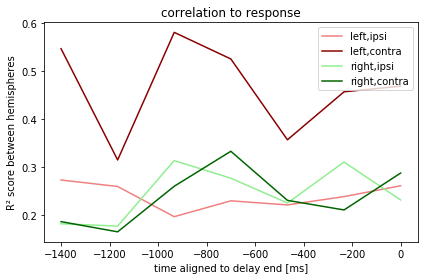

In [128]:
plt.figure(figsize=(6,4))
plt.plot(x_acc,pearson_li_cont, color='lightcoral', label='left,ipsi')
plt.plot(x_acc,pearson_lc_cont, color='darkred', label='left,contra')
plt.plot(x_acc,pearson_ri_cont, color='lightgreen', label='right,ipsi')
plt.plot(x_acc,pearson_rc_cont, color='darkgreen', label='right,contra')
#plt.axhline(0, dashes=[5,5], color='grey')
plt.xlabel('time aligned to delay end [ms]')
plt.ylabel('R² score between hemispheres')
plt.title('correlation to response')
plt.legend()
plt.tight_layout()

#plt.savefig('../Figures/Neural/CWvsCCW/hemispheres/Hemispheres_predictionCorrelation_DelayDecoder.png', dpi=200)
plt.show()

Scatterplot for single timepoints:

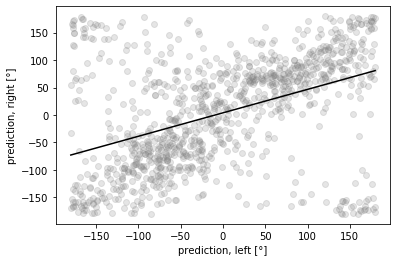

In [102]:
x_ang = np.linspace(-180,180,500)
delay_time=6
params = LinearRegression().fit((np.concatenate(pred_angle_left_cont, axis=1)[delay_time,:]*180/np.pi).reshape(-1,1), (np.concatenate(pred_angle_right_cont, axis=1)[delay_time,:]*180/np.pi).reshape(-1,1))

plt.figure()
plt.scatter(np.concatenate(pred_angle_left_cont, axis=1)[delay_time,:]*180/np.pi, np.concatenate(pred_angle_right_cont, axis=1)[delay_time,:]*180/np.pi, color='grey', alpha=0.2)
plt.plot(x_ang, params.coef_[0]*x_ang+params.intercept_[0], color='k')
plt.xlabel('prediction, left [°]')
plt.ylabel('prediction, right [°]')
#plt.savefig('../Figures/Neural/CWvsCCW/hemispheres/CWvsCCWCorrelation_LeftRight.png', dpi=200)
plt.show()



In [134]:
max(df_Sa0['saccade_angle'].values)

359.23629181497887

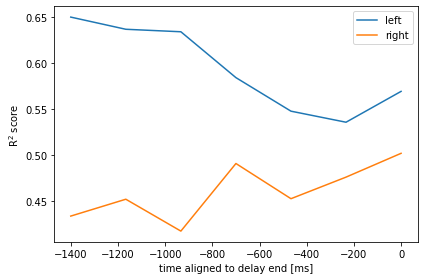

In [137]:
pearson_left=[]
pearson_right=[]
for i in range(len(pred_angle_left[0])):

    pearson_left.append(pearsonr(df_Sa0['saccade_angle'].values*np.pi/180-np.pi, np.concatenate(pred_angle_left_cont, axis=1)[i,:])[0])
    pearson_right.append(pearsonr(df_Sa0['saccade_angle'].values*np.pi/180-np.pi, np.concatenate(pred_angle_right_cont, axis=1)[i,:])[0])

plt.figure()
plt.plot(x_acc, pearson_left, label='left')
plt.plot(x_acc, pearson_right, label='right')
plt.xlabel('time aligned to delay end [ms]')
plt.ylabel('R$^2$ score')
plt.legend()
plt.tight_layout()
#plt.savefig('../Figures/Neural/CWvsCCW/hemispheres/Hemispheres_predictionCorrelationAgainstResponse_fullDecoder.png', dpi=200)
plt.show()

## Analysis ipsi vs contralateral trials

In [ ]:
len(np.concatenate(pred_angle_left_cont, axis=1)[:,0])

In [ ]:
left_ipsi = np.concatenate(pred_angle_left_cont, axis=1)[:,targ_left]
left_contra = np.concatenate(pred_angle_left_cont, axis=1)[:,targ_right]
right_ipsi = np.concatenate(pred_angle_right_cont, axis=1)[:,targ_left]
right_contra = np.concatenate(pred_angle_right_cont, axis=1)[:,targ_right]

In [ ]:
r2_left_ipsi=[]
r2_left_contra=[]
r2_right_ipsi=[]
r2_right_contra=[]
for i in range(len(left_ipsi)):
    dat ={'x': df_Sa0['saccade_angle'].values[targ_left], 'y':left_ipsi[i]}
    mod=sf.ols('y~x',data=dat)
    res=mod.fit()
    r2_left_ipsi.append(res.rsquared)
    
    dat ={'x': df_Sa0['saccade_angle'].values[targ_right], 'y':left_contra[i]}
    mod=sf.ols('y~x',data=dat)
    res=mod.fit()
    r2_left_contra.append(res.rsquared)
    
    dat ={'x': df_Sa0['saccade_angle'].values[targ_right], 'y':right_ipsi[i]}
    mod=sf.ols('y~x',data=dat)
    res=mod.fit()
    r2_right_ipsi.append(res.rsquared)
    
    dat ={'x': df_Sa0['saccade_angle'].values[targ_left], 'y':right_contra[i]}
    mod=sf.ols('y~x',data=dat)
    res=mod.fit()
    r2_right_contra.append(res.rsquared)

In [ ]:
plt.figure()
plt.plot(x_acc, r2_left_contra, color='darkred',label='left, contra')
plt.plot(x_acc, r2_left_ipsi, color='salmon',label='left, ipsi')
plt.plot(x_acc, r2_right_contra,color='darkgreen', label='right, contra')
plt.plot(x_acc, r2_right_ipsi,color='lightgreen', label='right, ipsi')
plt.legend()